In [1]:
!pip install -U tensorflow>=2.5

In [2]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  #Source: https://i.pinimg.com/originals/b2/bd/6e/b2bd6e898354c0cf3216f4193815b271.jpg
  'Car1' : 'https://i.pinimg.com/originals/b2/bd/6e/b2bd6e898354c0cf3216f4193815b271.jpg',
  'Car2' : 'https://www.carblogindia.com/wp-content/uploads/2020/05/IMG_1874.jpg',
  'Car3' : 'https://www.outlookindia.com/outlooktraveller/resizer.php?src=https://www.outlookindia.com/outlooktraveller/public/uploads/articles/explore/driving-holiday.jpg&w=500&h=400',
  'Cardog': 'https://c8.alamy.com/comp/TDR4R6/shiba-inu-dog-in-a-car-TDR4R6.jpg',
  'Carpng': 'https://www.get-real.org/wp-content/uploads/2019/03/Red-car.png',
  'Car4': 'https://www.aitrends.com/wp-content/uploads/2019/10/10-4ParallelDriving-2.jpg',
  'Car5': 'https://external-preview.redd.it/H1Nk4a4xYAP2jwe5I_lJ4ztBu0H9s7ybfkWHpNESctM.jpg?auto=webp&s=adf61d85ac8f597ab5531ef5906dda8f972acdbe',
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
   
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

In [4]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [5]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1650350 sha256=93e37dff42c95aa5f8ca21229dcbade3eb96f4bce33f3ac75eeb34f766ebc6ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-9a6nwqta/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [7]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [8]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet152 V1 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet152 V1 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1


In [9]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


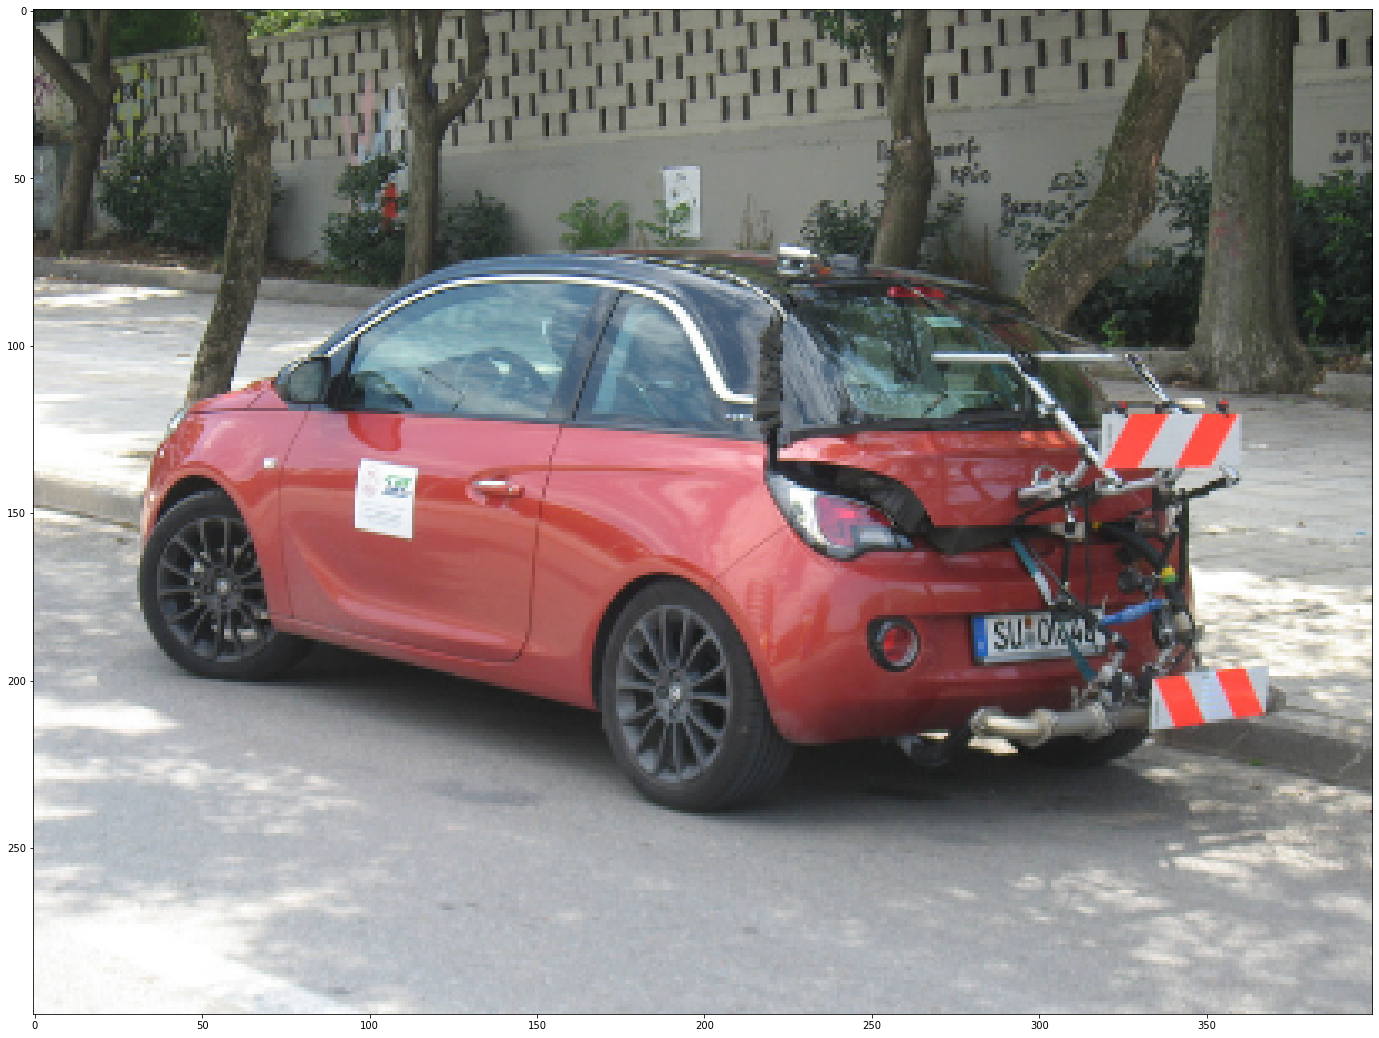

In [10]:
#@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
selected_image = 'Carpng' # @param ['Car1','Car2','Cardog','Carpng', 'Car4', 'Car5', 'Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [11]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['num_detections', 'detection_boxes', 'raw_detection_boxes', 'detection_scores', 'raw_detection_scores', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_classes'])


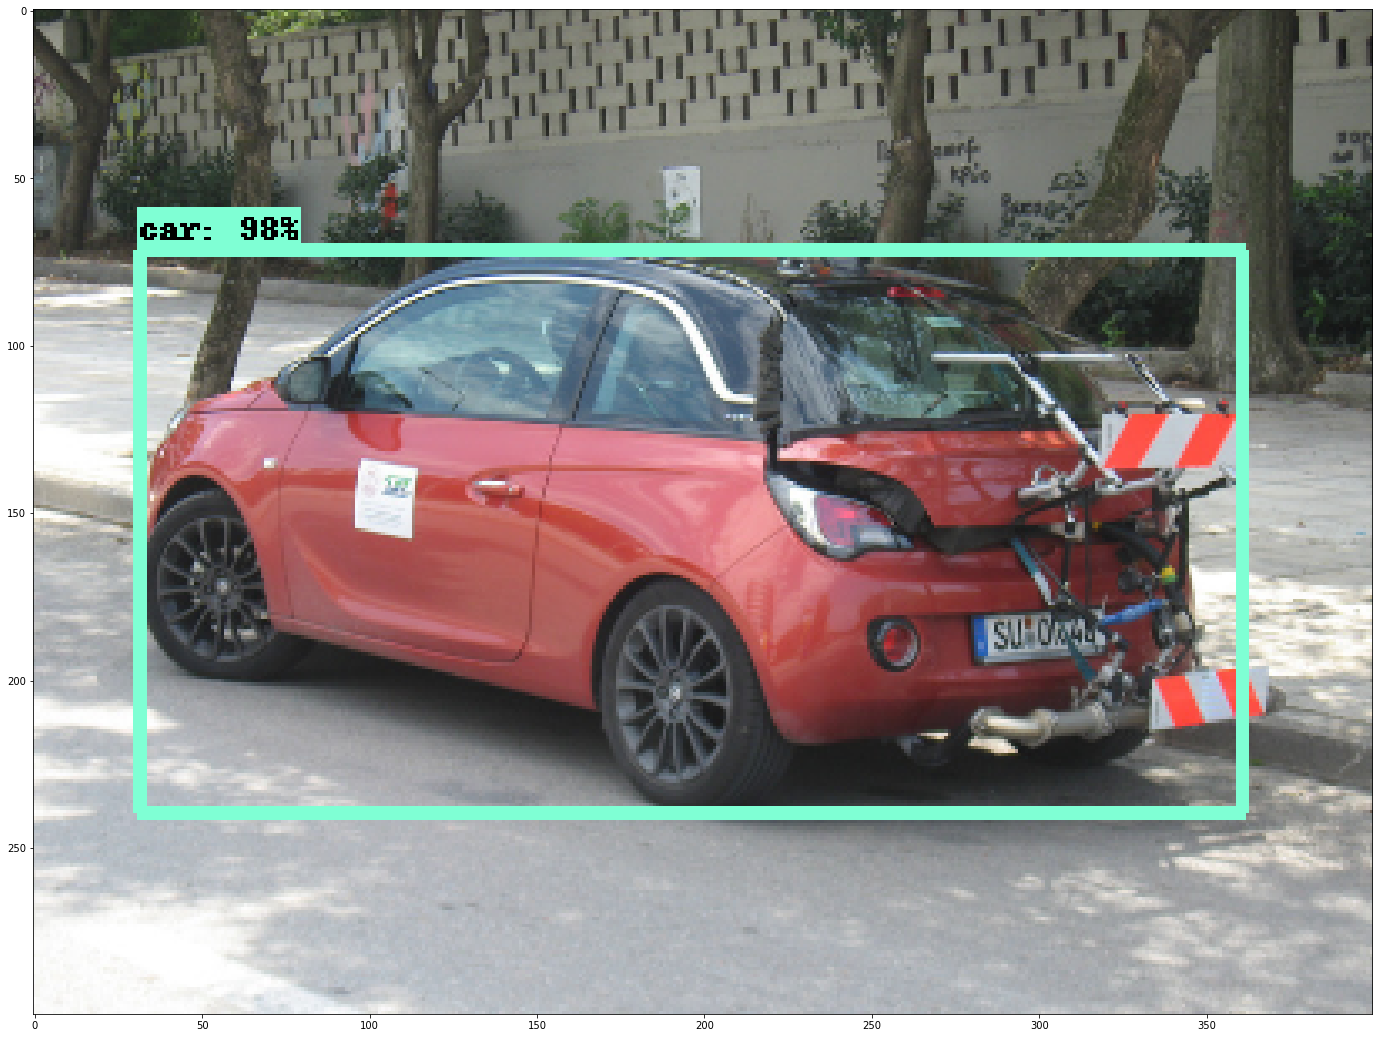

In [12]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=20,
      min_score_thresh=.80,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

In [13]:
coordinates = viz_utils.return_coordinates(
                        image_np_with_detections[0],
                        np.squeeze(result['detection_boxes'][0]),
                        np.squeeze((result['detection_classes'][0] + label_id_offset).astype(int)).astype(np.int32),
                        np.squeeze( result['detection_scores'][0]),
                        category_index,
                        use_normalized_coordinates=True,
                        line_thickness=8,
                        min_score_thresh=0.80)

In [14]:
def img_coord():# returns image ndarray and box coords
  [X1, X2, Y1, Y2] = coordinates[0][0], coordinates[0][1], coordinates[0][2], coordinates[0][3]  
  return image_np, [Y1, Y2, X1, X2] 

In [15]:
####
####  COMPRESSION STAGE
####

In [16]:
#Libraries

import os
import sys
import cv2
import math
import scipy
import scipy.misc

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc
from scipy import fftpack
from PIL import Image
from scipy import ndimage
from scipy import optimize

%matplotlib inline

In [17]:
#Common functions

def load_image(path):
    """ Load image from path. Return a numpy array """
    image = Image.open(path)
    return np.asarray(image) #/ 255

def preserve_ROI( X_reconstructed, image, ROI_coord ):
    i = 0
    while i <len(X_reconstructed):
        j = 0
        while j <len(X_reconstructed[i]):
            if (i>=ROI_coord[0][0] ):
                if( i<=ROI_coord[1][0]):
                    if( j>=ROI_coord[0][1] ):
                        if( j<=ROI_coord[1][1]):
                            #print(str(i)+","+str(j))
                            X_reconstructed[i][j][0] = image[i][j][0]
                            X_reconstructed[i][j][1] = image[i][j][1]
                            X_reconstructed[i][j][2] = image[i][j][2]
            j+=1
        i+=1
    return X_reconstructed

def PlotGraphs(data, label_x):
  x=data[0]
  y=data[1]
  z=data[2]
  plt.scatter(x, y,c='red')
  plt.plot(x, y)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("CR")
  plt.show()

  plt.scatter(x, z,c='green')
  plt.plot(x, z)
  plt.xlabel(label_x)
  plt.xticks(x) 
  plt.ylabel("PSNR")
  plt.show()

class DCT():
    def __init__(self):
        self.count = 0

    # The Function generates a N point DCT Matrix which is based on type 2 DCT
    # whose formula can be found as Equation 4 (pg 2) in the Paper.
    # We use N = 8 when we are dealing with JPEG Compression, hence the same 
    # value has been used here.

    def generate_N_Point_DCT(self, N = 8, roundingFactor = 4):
        D = np.random.randn(N,N)
        for i in range(N):
            for j in range(N):
                if i==0:
                    D[i,j] = np.round(1/np.sqrt(N),roundingFactor)
                else:
                    D[i,j] = np.round(np.sqrt(2/N) * np.cos(((2*j + 1)*i*np.pi)/(2*N)),roundingFactor)
        return D

    # This function calculates the DCT transform using the DCT Matrix using formula 5 (pg 3 in the paper).

    def calculateDCT(self, a):
        dctMatrix = self.generate_N_Point_DCT()
        return np.round(dctMatrix @ a @ dctMatrix.T,4)

class quantizationClass():

    def __init__(self):
        self.count = 0

    # The (8*8) Quantization Matrix which is predefined here is the standard
    # matrix that is used in JPEG Compression.
    # This function calculates the Quantization Matrix depending on the 
    # percentage of compressed image size required.
    # If the desired percentage is 90%, more information is retained and the 
    # compression ratio turns out to be less.
    # If the desired percentage is 10%, more compression takes place at the
    # cost of loss of information.
    # 50% is the Standard value that is chosen for JPEG compression, hence same 
    # value has been used here.

    def getQuantizationMatrix(self, requiredQualityLevel = 50):
        Q = np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
        if requiredQualityLevel == 50:
            return Q
        elif requiredQualityLevel>50:
            Q = (Q * ((100-requiredQualityLevel)/50)).astype('int')
            Q = np.where(Q>255,255,Q)
            return Q
        else:
            Q = (Q * (50/requiredQualityLevel)).astype('int')
            Q = np.where(Q>255,255,Q)
            return Q

    # This function gives us the quantized output which can be used to 
    # find the relevant compressions in the image.

    def quantizedOutputs(self, D):
        Q = self.getQuantizationMatrix()
        C = D//Q
        return C

In [30]:
#Metric functions
#import imageio

def psnr( original, altered ):
    mse = np.mean( (original - altered) ** 2 )
    if mse == 0:
        return 100 
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def cr( original_img, altered_img ):
    # scipy.misc.imsave('original.jpg', original_img)
    # scipy.misc.imsave('altered.jpg', altered_img)    

    altered_img=cv2.imwrite("altered.png", altered_img)
    print("Output File Size: "+str(os.path.getsize("altered.png")))
    original_img=cv2.imwrite("original.png", original_img)
    print("Input File Size: "+str(os.path.getsize("original.png")))
    return ( os.path.getsize("altered.png")/os.path.getsize("original.png") )
    
def metrics( original_img, altered_img ):
    print("Achieved Peak Signal to Noise Ratio: " + str( psnr( original_img, altered_img ) ))
    print("Achieved Compression Ratio: " + str( cr( original_img, altered_img ) ))  
    #return cr( original_img, altered_img ), psnr( original_img, altered_img )        

In [19]:
#Funtions for KMeans method

def initialize_K_centroids(X, K):
    """ Choose K points from X at random """
    m = len(X)
    return X[np.random.choice(m, K, replace=False), :]


def find_closest_centroids(X, centroids):
    m = len(X)
    c = np.zeros(m)
    
    for i in range(m):
        # Find distances
        distances = np.linalg.norm(X[i] - centroids, axis=1)

        # Assign closest cluster to c[i]
        c[i] = np.argmin(distances)

    return c


def compute_means(X, idx, K):
    _, n = X.shape
    centroids = np.zeros((K, n))
    for k in range(K):
        examples = X[np.where(idx == k)]
        mean = [np.mean(column) for column in examples.T]
        centroids[k] = mean
    return centroids


def find_k_means(X, K, max_iters=10):
    centroids = initialize_K_centroids(X, K)
    previous_centroids = centroids
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_means(X, idx, K)
        if (previous_centroids==centroids).all():
            # The centroids aren't moving anymore.
            return centroids
        else:
            previous_centroids = centroids

    return centroids, idx


def Kmeans_compression( image, K = 5, max_iters = 5 ):

    w, h, d = image.shape
    print('Image found with width: {}, height: {}, depth: {}'.format(w, h, d))
    
    # Get the feature matrix X
    X = image.reshape((w * h, d))
    #K = 5 # the number of colors/clusters in the image

    # Get colors
    print('Running K-means')
    colors, _ = find_k_means( X, K, max_iters )

    # Indexes for color for each pixel
    idx = find_closest_centroids(X, colors)

    # Reconstruct the image
    idx = np.array(idx, dtype=np.uint8)
    X_reconstructed = np.array(colors[idx, :], dtype=np.uint8).reshape((w, h, d))#* 255 placed bfore comma 
    
    return X_reconstructed

In [20]:
#Functions for GA Method

def DecimalToBinary( decimal ): 
    binary, powr = 0, 0
    while( decimal >0 ):    
        binary += decimal%2 * pow(10, powr)
        decimal /= 2 
        decimal = int(decimal)
        powr += 1
    return binary
    
def BinaryToDecimal( binary ):
    decimal, powr= 0, 0
    while( binary != 0 ):
        decimal += binary%10 * pow(2, powr)
        binary = binary//10
        powr += 1
    return decimal    

def GA_compression( image, generations = 1 ):
    
    #w, h, d = image.shape
    #print('Image found with width: {}, height: {}, depth: {}'.format(w, h, d))
    print("Running Genetic Algortihm compression")
    X = np.zeros((len(image), len(image[0]), 3))
    X_final = np.zeros((len(image), len(image[0]), 3))
    itr = 1
    while( itr<=generations ):
        print(str(itr)+" Generation")
        #encode+fitness_process
        i = 0
        while i <len(X):
            j = 0
            while j <len(X[i]):
                
                X[i][j][0] = int( DecimalToBinary(image[i][j][0])/pow(10,itr) )
                X_final[i][j][0] = BinaryToDecimal(X[i][j][0]*pow(10,itr))
                
                X[i][j][1] = int( DecimalToBinary(image[i][j][1])/pow(10,itr) )
                X_final[i][j][1] = BinaryToDecimal(X[i][j][1]*pow(10,itr)) 
                
                X[i][j][2] = int( DecimalToBinary(image[i][j][2])/pow(10,itr) )
                X_final[i][j][2] = BinaryToDecimal(X[i][j][2]*pow(10,itr)) 
                
                j+=1
            i+=1
        print("...Done")
        itr+=1
    X_final = X_final.astype(int)
    return X_final

In [21]:
#Functions for DCT method

def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )
    #return np.fft.fft2.dct( np.fft.fft2.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')
    #return np.fft.fft2.idct( np.fft.fft2.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def DCT_compression( im, threshold ):    

    #im = cv2.imread(image_path)
    imsize = im.shape
    dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)] )

    # Threshold
    dct_thresh = dct * (abs(dct) > (threshold*np.max(dct)))
    percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    print ("Keeping only "+str(percent_nonzeros*100.0)+" of the DCT coefficients")

    im_dct = np.zeros(imsize)#regained image

    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            im_dct[i:(i+8),j:(j+8)] = idct2( dct_thresh[i:(i+8),j:(j+8)] )

    im_dct = im_dct.astype(np.uint8)
    return im_dct

(300, 400, 3)
360000
<class 'numpy.ndarray'>
Running DCT
Keeping only 5.174166666666666 of the DCT coefficients
Region of Interest Coordinates: 
[[72, 31], [239, 361]]
(300, 400, 3)
360000
<class 'numpy.ndarray'>
(300, 400, 3)
360000
<class 'numpy.ndarray'>
Achieved Peak Signal to Noise Ratio: 33.02859330648245
Output File Size: 140448
Input File Size: 233605
Achieved Compression Ratio: 0.6012200081333876


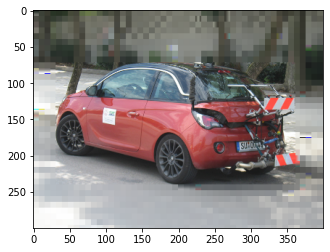

In [35]:
# Normal Operation: Single Image Implementation

if __name__ == '__main__':
    
    
    """
    try:
        image_path = "index.png"
        assert os.path.isfile(image_path)
    except (IndexError, AssertionError):
        print('Please specify an image')
    """
    
    image, [Y1, Y2, X1, X2] = img_coord()#cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = image[0]
    #Compresion method select: < 1 for Kmeans > < 2 for GA > < 3 for DCT >
    method = 3
    #X_compressed = np.zeros((len(image), len(image[0]), 3))

    print(image.shape)
    print(image.size)
    print(type(image))
    plt.imshow(image)
        
    if ( method == 1 ):#checked and working!!
        print("Running KMeans")
        X_compressed = Kmeans_compression( image, 7, 5 ) #Kmeans 
    elif ( method == 2 ):
        #checked and works till X_final, errors in saving as image due to float/int data confusion 
        print("Running GA")
        X_compressed = np.asarray( GA_compression( image, 5 ) , dtype=None, order=None )#Genetic Algorithm
    elif method == 3:
        print("Running DCT")
        X_compressed = np.asarray( DCT_compression( image, 0.1 ), dtype=None, order=None )#DCT Transform
    else : 
        print("Invalid Argument")
        
    #print(X_compressed.shape)
    #print(X_compressed.size)
    #print(type(X_compressed))
    #plt.imshow(X_compressed)
    
    #X1 = 30
    #X2 = 100
    #Y1 = 30
    #Y2 = 100
    ROI_coord = [[ X1, Y1 ],[ X2, Y2 ]]
    print("Region of Interest Coordinates: ")
    print(ROI_coord)
    
    #X_final = np.zeros((len(image), len(image[0]), 3))
    X_final = preserve_ROI( X_compressed, image, ROI_coord )

    print(image.shape)
    print(image.size)
    print(type(image))
    print(X_final.shape)
    print(X_final.size)
    print(type(X_final))
    plt.imshow(X_final)
    
    #print(X_final)
    #image_final = cv2.cvtColor(X_final, cv2.COLOR_BGR2RGB)
    #cv2.imwrite('color_img.jpg', image_final)
    #cv2.imshow("image", image_final)
    
    #compressed_image = Image.fromarray(X_final)        
    #compressed_image.save('out.png')
    
    metrics( image, X_final )
    #cr, psnr = metrics( image, X_final )

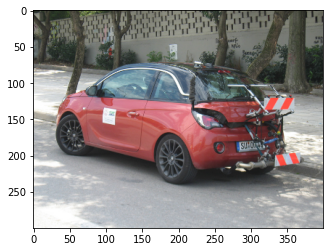

In [23]:
plt.imshow(image)

Original Image parameters: 
(300, 400, 3)
360000
<class 'numpy.ndarray'>
Region of Interest Coordinates: 
[[72, 31], [239, 361]]
Running DCT
Testing for threshold = 0.02
Keeping only 17.7425 of the DCT coefficients
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.700022914431365
Output File Size: 185281
Input File Size: 233605
Achieved Compression Ratio: 0.7931379893409816
Output File Size: 185281
Input File Size: 233605
Achieved Peak Signal to Noise Ratio: 34.700022914431365
Output File Size: 185281
Input File Size: 233605
Achieved Compression Ratio: 0.7931379893409816
Output File Size: 185281
Input File Size: 233605
Testing for threshold = 0.03
Keeping only 11.618333333333334 of the DCT coefficients
Metrics otained: 
Achieved Peak Signal to Noise Ratio: 34.050181835461615
Output File Size: 172881
Input File Size: 233605
Achieved Compression Ratio: 0.7400569337128914
Output File Size: 172881
Input File Size: 233605
Achieved Peak Signal to Noise Ratio: 34.050181835461615
Outpu

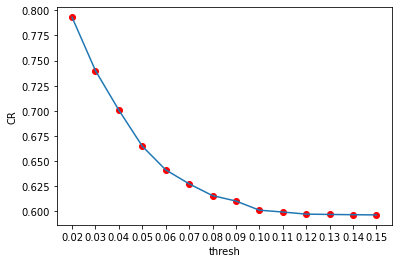

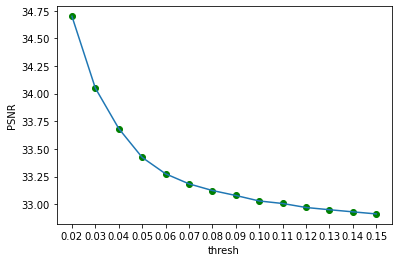

In [29]:
# Optimal Paramter Search Operation: In-loop implementaion for a test image to obtain optimal parameter values
# Uncomment last line in Metric fucntions to run this  
if __name__ == '__main__':
    
    
    """
    try:
        image_path = "index.png"
        assert os.path.isfile(image_path)
    except (IndexError, AssertionError):
        print('Please specify an image')
    """
    
    image, [Y1, Y2, X1, X2] = img_coord()
    image = image[0]
    method = 3 #Compresion method select: < 1 for Kmeans > < 2 for GA > < 3 for DCT >
    print("Original Image parameters: ")
    print(image.shape)
    print(image.size)
    print(type(image))
    #plt.imshow(image)
    ROI_coord = [[ X1, Y1 ],[ X2, Y2 ]]
    print("Region of Interest Coordinates: ")
    print(ROI_coord)
        
    if ( method == 1 ):#checked and working!!
        print("Running KMeans")
        eval_data = np.zeros((15-3 +1, 3), dtype=float)#col1=K, col2=cr, col3=psnr
        K = 3
        i = 0
        while K<=15:
          eval_data[i][0] = K
          print("Testing for K = "+str(K))
          X_compressed = Kmeans_compression( image, K, 5 ) #Kmeans 
          X_final = preserve_ROI( X_compressed, image, ROI_coord )
          print("Metrics otained: ")
          eval_data[i][1], eval_data[i][2]  = metrics( image, X_final )
          K+=1
          i+=1
        print("Data obtained after evaluation: ")
        print(eval_data)
        PlotGraphs(np.ndarray.transpose(eval_data), 'K')


    elif ( method == 2 ):
        #checked and works till X_final, errors in saving as image due to float/int data confusion 
        print("Running GA")
        gen = 1
        i=0
        eval_data = np.zeros((7-1 +1, 3), dtype=float)#col1=K, col2=cr, col3=psnr
        while gen<=7:
          eval_data[i][0] = gen
          print("Testing for gen = "+str(gen))
          X_compressed = np.asarray( GA_compression( image, gen ) , dtype=None, order=None )#Genetic Algorithm 
          X_final = preserve_ROI( X_compressed, image, ROI_coord )
          print("Metrics otained: ")
          metrics( image, X_final )
          eval_data[i][1], eval_data[i][2] = metrics( image, X_final )
          gen+=1
          i+=1
        print("Data obtained after evaluation: ")
        print(eval_data)
        PlotGraphs(np.ndarray.transpose(eval_data), 'gen')

    
    elif method == 3:
        print("Running DCT")
        thresh = 0.02
        i=0
        eval_data = np.zeros((15-2 +1, 3), dtype=float)#col1=K, col2=cr, col3=psnr
        while thresh<=0.15:
          eval_data[i][0] = thresh
          print("Testing for threshold = "+str(thresh))
          X_compressed = np.asarray( DCT_compression( image, thresh ), dtype=None, order=None )#DCT Transform 
          X_final = preserve_ROI( X_compressed, image, ROI_coord )
          print("Metrics otained: ")
          metrics( image, X_final )
          eval_data[i][1], eval_data[i][2] = metrics( image, X_final )
          thresh+=0.01
          i+=1
        print("Data obtained after evaluation: ")
        print(eval_data)
        PlotGraphs(np.ndarray.transpose(eval_data), 'thresh')
    

    else : 
        print("Invalid Argument")
        
    

In [25]:
"""''def return_coordinates(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    groundtruth_box_visualization_color='black',
    skip_scores=False,
    skip_labels=False):
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_score_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in category_index.keys():
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
        box_to_display_str_map[box].append(display_str)
        box_to_score_map[box] = scores[i]
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  coordinates_list = []
  counter_for = 0
  for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box
    height, width, channels = image.shape
    ymin = int(ymin*height)
    ymax = int(ymax*height)
    xmin = int(xmin*width)
    xmax = int(xmax*width)
    coordinates_list.append([ymin, ymax, xmin, xmax, (box_to_score_map[box]*100)])
    counter_for = counter_for + 1

  return coordinates_list"""''


"''def return_coordinates(\n    image,\n    boxes,\n    classes,\n    scores,\n    category_index,\n    instance_masks=None,\n    instance_boundaries=None,\n    keypoints=None,\n    use_normalized_coordinates=False,\n    max_boxes_to_draw=20,\n    min_score_thresh=.5,\n    agnostic_mode=False,\n    line_thickness=4,\n    groundtruth_box_visualization_color='black',\n    skip_scores=False,\n    skip_labels=False):\n  # Create a display string (and color) for every box location, group any boxes\n  # that correspond to the same location.\n  box_to_display_str_map = collections.defaultdict(list)\n  box_to_color_map = collections.defaultdict(str)\n  box_to_instance_masks_map = {}\n  box_to_instance_boundaries_map = {}\n  box_to_score_map = {}\n  box_to_keypoints_map = collections.defaultdict(list)\n  if not max_boxes_to_draw:\n    max_boxes_to_draw = boxes.shape[0]\n  for i in range(min(max_boxes_to_draw, boxes.shape[0])):\n    if scores is None or scores[i] > min_score_thresh:\n      box =